In [7]:
# --- 0. Setup ---------------------------------------------------------------
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from pprint import pprint
import math
import pyarrow.dataset as ds


In [8]:
fno       = 10709             # logical bunch number (1-based)
beam      = "B1"                    # 1 or 2   ↩︎ keep this consistent with BCTFR.B?R4
DATADIR = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/')
RAWDATA = DATADIR / 'rawdata'
FILLINFO = DATADIR / "fills-info"
fpat = LHCFillingPattern(fno, RAWDATA)
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
emitH_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_H"
emitV_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_V" 


In [9]:
FILLINFO

PosixPath('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/fills-info')

In [10]:
beam = 'B1'          # 'B1' or 'B2'
ip   = 'ip1'         # 'ip1', 'ip2', 'ip5', 'ip8'

# LR array and "filled + LR>0" flag
lr = fpat.lrencounters[beam][ip]               # length-3564 array
filled = fpat.bunches_b1

is_filled_lr = np.zeros(3564, dtype=bool)
is_filled_lr[filled] = lr[filled] > 0   

### Family 1 

In [11]:
fpat.bunchtrainsDF_b1 = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1['id'] != 0]
fpat.bunchtrainsDF_b1
trains_gap_long = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1['gap'].isin([32, 63])]

# ── 2.  first bunch of those trains  (= first after the long gap) ─────────
Family_1 = trains_gap_long['bid_first'].to_numpy()
print("bid_firsts after gap = 32 or 63:\n", Family_1)
print("Number of such trains:", len(Family_1))

bid_firsts after gap = 32 or 63:
 [  55  208  404  600  796  949 1102 1298 1494 1690 1843 1996 2192 2388
 2584 2725 2878 3074 3270]
Number of such trains: 19


### Family 2

In [12]:
df = fpat.bunchtrainsDF_b1.sort_values("bid_first").reset_index(drop=True)
orbit_len = 3564  # full turn

# ─── 1. Compute the gap AFTER each train ──────────────────────────────────
next_start = df["bid_first"].shift(-1).fillna(orbit_len).astype(int)
df["gap_after"] = next_start - df["bid_last"] - 1

# ─── 2. Find the last bunches before a big gap (32 or 63) ─────────────────
mask_big_gap = df["gap_after"]>= 31
Family_2 = df.loc[mask_big_gap, "bid_last"].to_numpy(int)
print("Last bunches before 32/63-slot gaps:\n", Family_2)
print("Number of such bunches:", len(Family_2))

Last bunches before 32/63-slot gaps:
 [ 176  372  568  764  917 1070 1266 1462 1658 1811 1964 2160 2356 2552
 2662 2846 3042 3238 3434]
Number of such bunches: 19


### Family 3

In [13]:
def first_maxima_per_train(df, lr_array):
    peak_slots = []
    peak_vals  = []

    for _, row in df.iterrows():
        bids      = np.asarray(row["bids"], dtype=int)
        lr_train  = lr_array[bids]

        max_val   = lr_train.max()                 # global max in this train
        first_idx = np.where(lr_train == max_val)[0][0]   # first occurrence
        peak_slots.append(bids[first_idx])
        peak_vals.append(max_val)

    return np.array(peak_slots, dtype=int), np.array(peak_vals)


Family_3, peak_vals = first_maxima_per_train(fpat.bunchtrainsDF_b1, lr)

print("First-maximum slot of each train:\n", Family_3)
print("Number of such bunches:", len(Family_3))

First-maximum slot of each train:
 [  71  114  157  224  267  310  353  420  463  506  549  616  659  702
  745  812  855  898  965 1008 1051 1118 1161 1204 1247 1314 1357 1400
 1443 1510 1553 1596 1639 1706 1749 1792 1859 1902 1945 2012 2055 2098
 2141 2208 2251 2294 2337 2404 2447 2490 2533 2600 2643 2741 2784 2827
 2894 2937 2980 3023 3090 3133 3176 3219 3286 3329 3372 3415]
Number of such bunches: 68


### Family 4

In [14]:
df_gap = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1['gap'].isin([32, 63])]

Family_4 = (df_gap['bid_first'] + 6).to_numpy(int)
print("7-th bunch in each long-gap train:\n", Family_4)
print("Number of such bunches:", len(Family_4))

7-th bunch in each long-gap train:
 [  61  214  410  606  802  955 1108 1304 1500 1696 1849 2002 2198 2394
 2590 2731 2884 3080 3276]
Number of such bunches: 19


### Family 5

In [15]:
df_gap = (
    fpat.bunchtrainsDF_b1
      .loc[fpat.bunchtrainsDF_b1['gap'].isin([8])]
      .query("nbunches >= 15")               # ensure a 15-th bunch exists
)

Family_5 = (df_gap['bid_first'] + 14).to_numpy(int)
print("15-th bunch in each long-gap train:\n", Family_5)
print("Number of such bunches:", len(Family_5))

15-th bunch in each long-gap train:
 [ 112  155  265  308  351  461  504  547  657  700  743  853  896 1006
 1049 1159 1202 1245 1355 1398 1441 1551 1594 1637 1747 1790 1900 1943
 2053 2096 2139 2249 2292 2335 2445 2488 2531 2641 2782 2825 2935 2978
 3021 3131 3174 3217 3327 3370 3413]
Number of such bunches: 49


### Family 6

In [16]:
df = fpat.bunchtrainsDF_b1.sort_values("bid_first").reset_index(drop=True)

# ── 1.  find rows where the NEXT train’s gap is 8  →  shift(+1) backward ───
train_before_small_gap = (
    df.shift(1)                              # previous train
      .loc[df["gap"] == 8]                   # only where current gap is 8
      .dropna()                              # drop the first row if needed
      .query("nbunches >= 27")               # ensure 27 bunches exist
)

# ── 2.  slot of the 27-th bunch from the start of each selected train ───────
Family_6 = (train_before_small_gap["bid_first"] + 26).to_numpy(int)
print("27-th bunch (trains right before a small gap 8):", Family_6)
print("How many:", len(Family_6))


27-th bunch (trains right before a small gap 8): [  81  124  234  277  320  430  473  516  626  669  712  822  865  975
 1018 1128 1171 1214 1324 1367 1410 1520 1563 1606 1716 1759 1869 1912
 2022 2065 2108 2218 2261 2304 2414 2457 2500 2610 2751 2794 2904 2947
 2990 3100 3143 3186 3296 3339 3382]
How many: 49


### Family 7

In [17]:

df_small_gap = fpat.bunchtrainsDF_b1.query("gap == 8").copy()

# ── 2.  the first bunch right after that small gap is simply bid_first ────
Family_7 = df_small_gap["bid_first"].astype(int).to_numpy()
print("First bunch after each 8-slot gap:\n", Family_7)
print("Number of such bunches:", len(Family_7))


First bunch after each 8-slot gap:
 [  98  141  251  294  337  447  490  533  643  686  729  839  882  992
 1035 1145 1188 1231 1341 1384 1427 1537 1580 1623 1733 1776 1886 1929
 2039 2082 2125 2235 2278 2321 2431 2474 2517 2627 2768 2811 2921 2964
 3007 3117 3160 3203 3313 3356 3399]
Number of such bunches: 49


### Family 8

In [18]:

df = fpat.bunchtrainsDF_b1.sort_values("bid_first").reset_index(drop=True)

# ── 1. trains that START after a small gap (gap == 8) ────────────────────
rows_with_small_gap = df["gap"] == 8           # True for each small-gap train

# ── 2. the train *before* each small gap (shift up by 1 row) ─────────────
train_before_gap8 = df.shift(1).loc[rows_with_small_gap].dropna()

# ── 3. its own last bunch is the bunch right before the 8-slot gap ───────
Family_8 = train_before_gap8["bid_last"].astype(int).to_numpy()
print("Last bunch before each 8-slot gap:\n", Family_8)
print("Number of such bunches:", len(Family_8))

Last bunch before each 8-slot gap:
 [  90  133  243  286  329  439  482  525  635  678  721  831  874  984
 1027 1137 1180 1223 1333 1376 1419 1529 1572 1615 1725 1768 1878 1921
 2031 2074 2117 2227 2270 2313 2423 2466 2509 2619 2760 2803 2913 2956
 2999 3109 3152 3195 3305 3348 3391]
Number of such bunches: 49


In [19]:
# ───────────────────────────────────────────
# 1) User parameters
# ───────────────────────────────────────────
beam      = "B1"     # "B1" or "B2"
threshold = 1e11     # intensity threshold

Family_1 = np.array(Family_1)  # fill in your actual slot lists
Family_2 = np.array(Family_2)
Family_3 = np.array(Family_3)
Family_4 = np.array(Family_4)
Family_5 = np.array(Family_5)
Family_6 = np.array(Family_6)
Family_7 = np.array(Family_7)
Family_8 = np.array(Family_8)

In [20]:

families = {
    "Family_1": Family_1,
    "Family_2": Family_2,
    "Family_3": Family_3,
    "Family_4": Family_4,
    "Family_5": Family_5,
    "Family_6": Family_6,
    "Family_7": Family_7,
    "Family_8": Family_8,
}

# ───────────────────────────────────────────
# 2) Paths & variable names
# ───────────────────────────────────────────
#DATADIR   = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/')
#RAWDATA   = DATADIR / 'rawdata'
#FILLINFO  = DATADIR / "fills-info"

#int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
#emitH_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_H"
#emitV_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_V"

# ───────────────────────────────────────────
# 3) Load fill modes & pattern only to get INJPHYS window
# ───────────────────────────────────────────
#fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")


# Injection

In [97]:

def load_INJPHYS(var: str) -> pd.Series:
    sub  = fbmodes.loc[fno]
    rows = sub.query("BMODE=='INJPHYS'").sort_values("tsStart")
    if rows.empty:
        rows = sub.sort_values("tsStart").iloc[[0]]
    t0 = pd.to_datetime(rows["tsStart"].iloc[0], utc=True)
    t1 = pd.to_datetime(rows["tsEnd"  ].iloc[0], utc=True)
    s = pd.read_parquet(RAWDATA / f"HX:FILLN={fno}", columns=[var])[var]
    s.index = pd.to_datetime(s.index, utc=True, errors="coerce")
return s.sort_index().loc[t0:t1].dropna()

ser_int   = load_INJPHYS(int_var)   # dtype: array of floats
ser_emith = load_INJPHYS(emitH_var)
ser_emitv = load_INJPHYS(emitV_var)



SyntaxError: 'return' outside function (2163007545.py, line 10)

In [ ]:
print(len(ser_emith))
print(len(ser_emitv))

57
57


In [ ]:
import numpy as np
import pandas as pd

# ───────────────────────────────────────────
# 6) Loop over families & slots, compute per-slot rates + diagnostics
# ───────────────────────────────────────────
def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    """
    Given a pd.Series whose values are array-like of per-slot floats,
    return a new Series giving the slot-th element (or NaN if missing).
    """
    return ser.apply(lambda arr: arr[slot] if hasattr(arr, '__len__') and len(arr) > slot else np.nan)

per_slot_h = {}       # slot → rate (units per hour)
per_slot_v = {}
fail_reasons = {fam: [] for fam in families}

for fam, slots in families.items():
    for slot in slots:
        reason = None
        # 6.1) intensity series for this slot
        df_i = extract_slot(ser_int, slot).to_frame("I")
        # 6.2) find first time I ≥ threshold
        valid = df_i[df_i["I"] >= threshold]
        if valid.empty:
            reason = f"int < {threshold:.1e}"
        else:
            t0 = valid.index[0]
            # 6.3) emittance series for this slot
            df_h = extract_slot(ser_emith, slot).to_frame("H")
            df_v = extract_slot(ser_emitv, slot).to_frame("V")
            # 6.4) first H/V after t0?
            h_after = df_h[df_h.index >= t0]["H"]
            v_after = df_v[df_v.index >= t0]["V"]
            if h_after.empty:
                reason = "no H after threshold"
            elif v_after.empty:
                reason = "no V after threshold"
            else:
                # 6.5) compute per-slot avg growth (end-point)
                h0 = h_after.iloc[0]
                v0 = v_after.iloc[0]
                t1 = max(df_h.index[-1], df_v.index[-1])
                h1 = df_h["H"].iloc[-1]
                v1 = df_v["V"].iloc[-1]
                
                dt_hours = (t1 - t0).total_seconds() / 3600.0
                per_slot_h[slot] = (h1 - h0) / dt_hours
                per_slot_v[slot] = (v1 - v0) / dt_hours

        if reason:
            per_slot_h[slot] = np.nan
            per_slot_v[slot] = np.nan
            fail_reasons[fam].append((slot, reason))

# ───────────────────────────────────────────
# 7) Aggregate to family mean, RMS, SEM
# ───────────────────────────────────────────
family_stats = {}
for fam, slots in families.items():
    h_vals = [per_slot_h[s] for s in slots if not np.isnan(per_slot_h[s])]
    v_vals = [per_slot_v[s] for s in slots if not np.isnan(per_slot_v[s])]
    n_h, n_v = len(h_vals), len(v_vals)

    family_stats[fam] = {
        'H_rate_avg': np.mean(h_vals)    if n_h else np.nan,
        'H_rms':      np.std(h_vals, ddof=1) if n_h > 1 else np.nan,
        'V_rate_avg': np.mean(v_vals)    if n_v else np.nan,
        'V_rms':      np.std(v_vals, ddof=1) if n_v > 1 else np.nan,
    }

df_family_inj = pd.DataFrame(family_stats).T

# ───────────────────────────────────────────
# 8) Compute SEM and keep only the requested columns
# ───────────────────────────────────────────
# compute counts per family
counts_h = np.array([len([s for s in families[fam] if not np.isnan(per_slot_h[s])])
                     for fam in df_family_inj.index])
counts_v = np.array([len([s for s in families[fam] if not np.isnan(per_slot_v[s])])
                     for fam in df_family_inj.index])

# add SEM columns
df_family_inj['H_sem'] = df_family_inj['H_rms'] / np.sqrt(counts_h)
df_family_inj['V_sem'] = df_family_inj['V_rms'] / np.sqrt(counts_v)

# select only the desired columns
df_family_inj = df_family_inj[
    ['H_rate_avg','H_rms','H_sem','V_rate_avg','V_rms','V_sem']
]

# ───────────────────────────────────────────
# 9) Output
# ───────────────────────────────────────────
print(df_family_inj)


          H_rate_avg     H_rms     H_sem  V_rate_avg     V_rms     V_sem
Family_1    0.560039  0.397264  0.091139    0.115748  0.096179  0.022065
Family_2    0.376768  0.352824  0.080943    0.282030  0.225365  0.051702
Family_3    0.569428  0.418737  0.050779    0.103376  0.109278  0.013252
Family_4    0.583896  0.393471  0.090268    0.111387  0.114531  0.026275
Family_5    0.604997  0.426184  0.060883    0.103480  0.090626  0.012947
Family_6    0.936438  1.467110  0.209587    0.121839  0.117966  0.016852
Family_7    0.689483  0.489826  0.069975    0.211141  0.169530  0.024219
Family_8    0.588972  0.537131  0.076733    0.181483  0.269606  0.038515


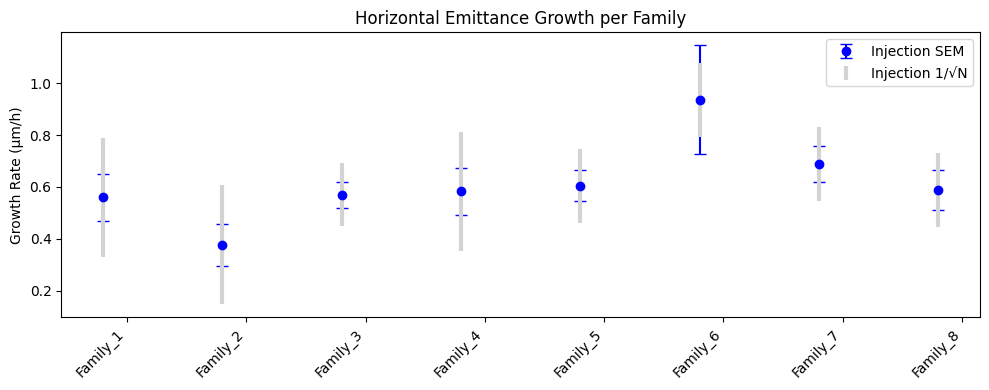

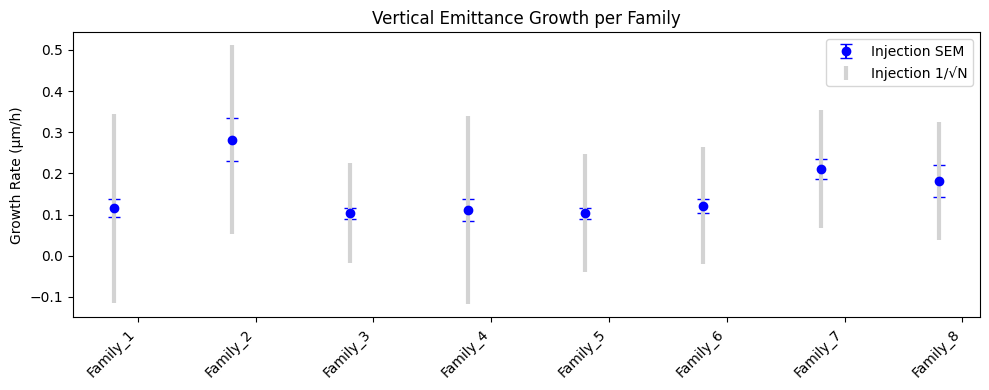

In [ ]:
# Prepare data
# ───────────────────────────────────────────
# Family list (should match both DataFrames)
families_list = df_family_inj.index.tolist()
x = np.arange(len(families_list))
width = 0.2

# Injection counts & 1/√N
counts_h_inj = np.array([
    len([s for s in families[fam] if not np.isnan(per_slot_h[s])])
    for fam in families_list
])
counts_v_inj = np.array([
    len([s for s in families[fam] if not np.isnan(per_slot_v[s])])
    for fam in families_list
])
inv_sqrtN_h_inj = 1 / np.sqrt(counts_h_inj, where=counts_h_inj>0)
inv_sqrtN_v_inj = 1 / np.sqrt(counts_v_inj, where=counts_v_inj>0)


# ───────────────────────────────────────────
# Horizontal Emittance Growth
# ───────────────────────────────────────────
plt.figure(figsize=(10,4))

# Injection: SEM
plt.errorbar(
    x - width,
    df_family_inj['H_rate_avg'],
    yerr=df_family_inj['H_sem'],
    fmt='o', capsize=4, label='Injection SEM', color='blue'
)
# Injection: 1/√N
plt.errorbar(
    x - width,
    df_family_inj['H_rate_avg'],
    yerr=inv_sqrtN_h_inj,
    fmt='none', ecolor='lightgray', elinewidth=3, capsize=0,
    label='Injection 1/√N'
)

plt.xticks(x, families_list, rotation=45, ha='right')
plt.title('Horizontal Emittance Growth per Family')
plt.ylabel('Growth Rate (µm/h)')
plt.legend()
plt.tight_layout()


# ───────────────────────────────────────────
# Vertical Emittance Growth
# ───────────────────────────────────────────
plt.figure(figsize=(10,4))

# Injection: SEM
plt.errorbar(
    x - width,
    df_family_inj['V_rate_avg'],
    yerr=df_family_inj['V_sem'],
    fmt='o', capsize=4, label='Injection SEM', color='blue'
)
# Injection: 1/√N
plt.errorbar(
    x - width,
    df_family_inj['V_rate_avg'],
    yerr=inv_sqrtN_v_inj,
    fmt='none', ecolor='lightgray', elinewidth=3, capsize=0,
    label='Injection 1/√N'
)

plt.xticks(x, families_list, rotation=45, ha='right')
plt.title('Vertical Emittance Growth per Family')
plt.ylabel('Growth Rate (µm/h)')
plt.legend()
plt.tight_layout()

plt.show()


# Brightness evolution

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path

# ───────────────────────── CONFIG ─────────────────────────
DATADIR      = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/')
RAWDATA_DIR  = DATADIR / 'rawdata'

INTENS_PV    = 'LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'      # per-bunch intensity PV  (array)
EMITH_PV     = 'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H'          # per-bunch horizontal emittance PV (array)            # fill you want to plot
TIME_STEP    = '30S'              # sampling cadence inside INJECTION
# fbmodes           – DataFrame with tsStart/tsEnd/BMODE (multi-index by fill)
# fpat.bunchtrainsDF_b1 – DataFrame with column 'bids' = list of bunch IDs
# families etc. not needed for this plot
# ───────────────────────────────────────────────────────────



/tmp/ipykernel_2350876/1319241661.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  I_raw   = load_INJPHYS(INTENS_PV).resample('1S').mean()
/tmp/ipykernel_2350876/1319241661.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  eps_raw = load_INJPHYS(EMITH_PV).resample('1S').mean()
/tmp/ipykernel_2350876/1319241661.py:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  grid = pd.date_range(t0, t1, freq='1S')
/tmp/ipykernel_2350876/1319241661.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eps_1s
/tmp/ipykernel_2350876/1319241661.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  step = pd.to_timedelta(TIME_STEP).seconds


Snapshots after sync: 421


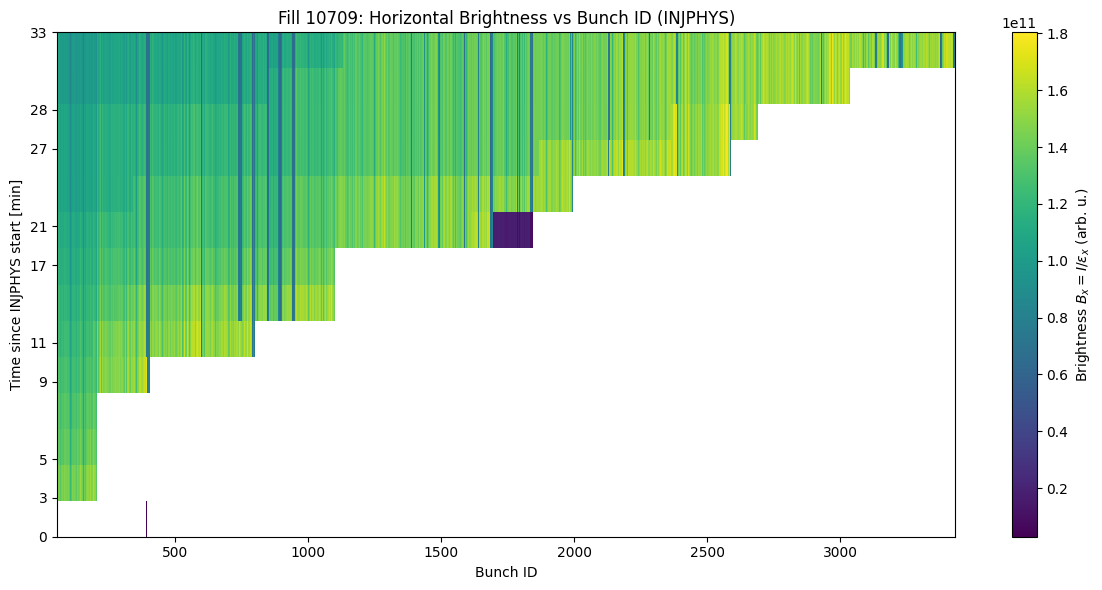

In [ ]:
TIME_STEP      = '30S'                 # spacing between waterfall lines
FILL_LIMIT_EPS = 30                    # seconds to forward/back-fill εx
B_CLIP_MAX     = 1e18                  # maximum brightness to plot
# ────────────────────────────────────────────────────────────────────

def load_INJPHYS(var: str) -> pd.Series:
    """Load PV `var` over the INJPHYS window of fill fno."""
    sub  = fbmodes.loc[fno]
    rows = sub.query("BMODE=='INJPHYS'").sort_values("tsStart")
    if rows.empty:
        rows = sub.sort_values("tsStart").iloc[[0]]  # fallback
    t0 = pd.to_datetime(rows["tsStart"].iloc[0], utc=True)
    t1 = pd.to_datetime(rows["tsEnd"  ].iloc[0], utc=True)
    s = pd.read_parquet(RAWDATA / f"HX:FILLN={fno}", columns=[var])[var]
    s.index = pd.to_datetime(s.index, utc=True, errors="coerce")
    return s.sort_index().loc[t0:t1].dropna()

# 1) Raw 1-s‐binned INJPHYS series
I_raw   = load_INJPHYS(INTENS_PV).resample('1S').mean()
eps_raw = load_INJPHYS(EMITH_PV).resample('1S').mean()

# 2) Build common 1-s grid
t0   = min(I_raw.index[0], eps_raw.index[0])
t1   = max(I_raw.index[-1], eps_raw.index[-1])
grid = pd.date_range(t0, t1, freq='1S')

I_1s   = I_raw.reindex(grid)            # NaN where missing
eps_1s = eps_raw.reindex(grid)

# 3) Forward/backward-fill εx up to ±FILL_LIMIT_EPS seconds
eps_filled = (
    eps_1s
    .fillna(method='ffill', limit=FILL_LIMIT_EPS)
    .fillna(method='bfill', limit=FILL_LIMIT_EPS)
)

# (Optional) fill small gaps in intensity too
I_filled = I_1s

# 4) Keep only times where both arrays exist
mask     = I_filled.notna() & eps_filled.notna()
I_sync   = I_filled[mask]
eps_sync = eps_filled[mask]

print("Snapshots after sync:", len(I_sync))

# 5) Down-sample to TIME_STEP cadence
step = pd.to_timedelta(TIME_STEP).seconds
stamps = I_sync.index[::step]
I_sync   = I_sync.loc[stamps]
eps_sync = eps_sync.loc[stamps]

# 6) Bunch IDs of interest
wanted = np.unique(
    np.concatenate(fpat.bunchtrainsDF_b1['bids'].dropna().values)
).astype(int)
wanted.sort()
idx = wanted  # convert to 0-based indices

# 7) Build brightness matrix (time × bunch)
brightness = pd.DataFrame(index=stamps, columns=wanted, dtype=float)

for ts in stamps:
    I_arr   = np.asarray(I_sync.loc[ts])
    eps_arr = np.asarray(eps_sync.loc[ts])

    # Skip if snapshot too short
    if I_arr.size < idx.max()+1 or eps_arr.size < idx.max()+1:
        continue

    # Mask zeros & negatives
    I_arr[I_arr <= 0]     = np.nan
    eps_arr[eps_arr <= 0] = np.nan

    B_arr = I_arr[idx] / eps_arr[idx]
    # Remove inf and clip outliers
    B_arr = np.nan_to_num(B_arr, nan=np.nan, posinf=np.nan, neginf=np.nan)
    B_arr = np.clip(B_arr, 0, B_CLIP_MAX)

    brightness.loc[ts] = B_arr

brightness.dropna(how='all', inplace=True)

# 8) Plot waterfall (linear scale)
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(
    brightness.values,
    origin='lower',
    aspect='auto',
    interpolation='none',
    extent=[wanted.min(), wanted.max(), 0, len(brightness)-1],
    cmap='viridis',        # linear colormap
    norm=None               # default linear scale
)

yticks = np.linspace(0, len(brightness)-1, 10, dtype=int)
ax.set_yticks(yticks)
ax.set_yticklabels(
    ((brightness.index[yticks] - brightness.index[0])
     .total_seconds() / 60).astype(int)
)
ax.set_xlabel('Bunch ID')
ax.set_ylabel('Time since INJPHYS start [min]')
fig.colorbar(im, ax=ax, label=r'Brightness $B_x = I/\varepsilon_x$ (arb. u.)')

plt.title(f'Fill {fno}: Horizontal Brightness vs Bunch ID (INJPHYS)')
plt.tight_layout()
plt.show()

# END of injection to start of stable

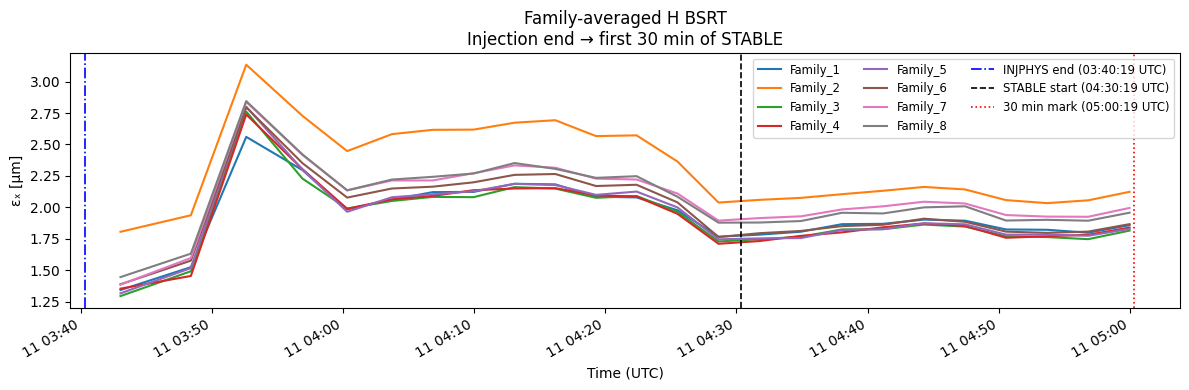

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0) Determine phase boundaries for this fill
# ------------------------------------------------------------------
sub = fbmodes.loc[fno].sort_values("tsStart")

# a) End of injection (INJPHYS end)
injphys_rows = sub.query("BMODE=='INJPHYS'")
if not injphys_rows.empty:
    t_inj_end = pd.to_datetime(injphys_rows["tsEnd"].iloc[-1], unit="ns", utc=True)
else:
    # fallback if missing
    t_inj_end = pd.to_datetime(sub["tsEnd"].iloc[0], unit="ns", utc=True)

# b) Start of STABLE
stable_row     = sub.query("BMODE=='STABLE'").sort_values("tsStart").iloc[0]
t_stable_start = pd.to_datetime(stable_row["tsStart"], unit="ns", utc=True)

# c) 30 min after stable start
t_next_end     = t_stable_start + pd.Timedelta(minutes=30)

# ------------------------------------------------------------------
# 1) Helper to load and slice a variable between two times
# ------------------------------------------------------------------
def load_range(var, t0, t1):
    s = pd.read_parquet(RAWDATA / f"HX:FILLN={fno}", columns=[var])[var]
    s.index = pd.to_datetime(s.index, utc=True, errors="coerce")
    return s.sort_index().loc[t0:t1].dropna()

# ------------------------------------------------------------------
# 2) Build the injection-window family-average DF
#    (INJPHYS end → STABLE start)
# ------------------------------------------------------------------
ser_emith_inj = load_range(emitH_var, t_inj_end, t_stable_start)

df_slots_inj = pd.DataFrame(
    ser_emith_inj
      .apply(lambda arr: arr if hasattr(arr, '__len__') else pd.NA)
      .tolist(),
    index=ser_emith_inj.index
)

df_family_new = pd.DataFrame(index=df_slots_inj.index)
for fam, slots in families.items():
    keep = [s for s in slots if s in df_slots_inj.columns]
    df_family_new[fam] = df_slots_inj[keep].mean(axis=1) if keep else pd.NA

# ------------------------------------------------------------------
# 3) Build the first-30-min-of-STABLE family-average DF
# ------------------------------------------------------------------
ser_emith_next = load_range(emitH_var, t_stable_start, t_next_end)

df_slots_next = pd.DataFrame(
    ser_emith_next
      .apply(lambda arr: arr if hasattr(arr, '__len__') else pd.NA)
      .tolist(),
    index=ser_emith_next.index
)

df_family_next = pd.DataFrame(index=df_slots_next.index)
for fam, slots in families.items():
    keep = [s for s in slots if s in df_slots_next.columns]
    df_family_next[fam] = df_slots_next[keep].mean(axis=1) if keep else pd.NA

# ------------------------------------------------------------------
# 4) Concatenate both windows
# ------------------------------------------------------------------
df_family_comb = pd.concat([df_family_new, df_family_next])
df_family_comb.index = pd.to_datetime(df_family_comb.index, utc=True, errors='coerce')
df_family_comb = df_family_comb.sort_index()

# ------------------------------------------------------------------
# 5) Plot family-averaged H BSRT with phase lines
# ------------------------------------------------------------------
plt.figure(figsize=(12,4))
for fam in df_family_comb.columns:
    plt.plot(df_family_comb.index, df_family_comb[fam], label=fam)

# vertical lines:
plt.axvline(t_inj_end,       color='blue',   linestyle='-.', linewidth=1.2,
            label=f'INJPHYS end ({t_inj_end:%H:%M:%S} UTC)')
plt.axvline(t_stable_start,  color='black',  linestyle='--', linewidth=1.2,
            label=f'STABLE start ({t_stable_start:%H:%M:%S} UTC)')
plt.axvline(t_next_end,      color='red',    linestyle=':',  linewidth=1.2,
            label=f'30 min mark ({t_next_end:%H:%M:%S} UTC)')

plt.title('Family-averaged H BSRT\nInjection end → first 30 min of STABLE')
plt.ylabel('εₓ [µm]')
plt.xlabel('Time (UTC)')
plt.xticks(rotation=30, ha='right')
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# ───────────────────────────────────────────
# 1) Phase limits for this fill (UTC):
#    use end of INJPHYS → start of STABLE
# ───────────────────────────────────────────
sub = fbmodes.loc[fno].sort_values("tsStart")

# find end of injection (INJPHYS)
injphys_rows = sub.query("BMODE=='INJPHYS'")
if not injphys_rows.empty:
    t_inj_end = pd.to_datetime(injphys_rows["tsEnd"].iloc[-1], unit='ns', utc=True)
else:
    # fallback to first tsEnd if no INJPHYS
    t_inj_end = pd.to_datetime(sub["tsEnd"].iloc[0], unit='ns', utc=True)

# find start of STABLE
stable_rows = sub.query("BMODE=='STABLE'")
if not stable_rows.empty:
    t_stable_start = pd.to_datetime(stable_rows["tsStart"].iloc[0], unit='ns', utc=True)
else:
    # fallback to last tsStart
    t_stable_start = pd.to_datetime(sub["tsStart"].iloc[-1], unit='ns', utc=True)

print(f"Injection end:   {t_inj_end}")
print(f"Stable start:    {t_stable_start}")

# helper to slice any variable between those limits
def load_range(var, t0, t1):
    s = pd.read_parquet(RAWDATA / f"HX:FILLN={fno}", columns=[var])[var]
    s.index = pd.to_datetime(s.index, utc=True, errors="coerce")
    return s.sort_index().loc[t0:t1].dropna()

# load H & V series for injection window
ser_emith_mid = load_range(emitH_var, t_inj_end, t_stable_start)
ser_emitv_mid = load_range(emitV_var, t_inj_end, t_stable_start)

print(f"H-series points in injection window: {len(ser_emith_mid)}")
print(f"V-series points in injection window: {len(ser_emitv_mid)}")

# ───────────────────────────────────────────
# 2) End-point growth rates  (µm h⁻¹)
# ───────────────────────────────────────────
per_slot_h_mid = {}
per_slot_v_mid = {}
slot_time_bounds = {}   # slot → (t0, t1)

for fam, slots in families.items():
    for slot in slots:
        h_ser = extract_slot(ser_emith_mid, slot).dropna().sort_index()
        v_ser = extract_slot(ser_emitv_mid, slot).dropna().sort_index()

        # horizontal
        if len(h_ser) >= 2:
            t0, h0 = h_ser.index[0],  h_ser.iloc[0]
            t1, h1 = h_ser.index[-1], h_ser.iloc[-1]
            rate_h = (h1 - h0) / ((t1 - t0).total_seconds() / 3600.0)
            per_slot_h_mid[slot] = rate_h
            slot_time_bounds[slot] = (t0, t1)
        else:
            per_slot_h_mid[slot] = np.nan

        # vertical
        if len(v_ser) >= 2:
            t0, v0 = v_ser.index[0],  v_ser.iloc[0]
            t1, v1 = v_ser.index[-1], v_ser.iloc[-1]
            rate_v = (v1 - v0) / ((t1 - t0).total_seconds() / 3600.0)
            per_slot_v_mid[slot] = rate_v
        else:
            per_slot_v_mid[slot] = np.nan

# ───────────────────────────────────────────
# 3) Aggregate to family mean ± SEM
# ───────────────────────────────────────────
def_families_mid = {}
for fam, slots in families.items():
    h_vals = [per_slot_h_mid[s] for s in slots if not np.isnan(per_slot_h_mid[s])]
    v_vals = [per_slot_v_mid[s] for s in slots if not np.isnan(per_slot_v_mid[s])]
    n_h, n_v = len(h_vals), len(v_vals)

    def_families_mid[fam] = {
        "H_rate_avg_mid": np.mean(h_vals) if n_h else np.nan,
        "H_rate_sem_mid":  np.std(h_vals, ddof=1) / np.sqrt(n_h) if n_h else np.nan,
        "V_rate_avg_mid": np.mean(v_vals) if n_v else np.nan,
        "V_rate_sem_mid":  np.std(v_vals, ddof=1) / np.sqrt(n_v) if n_v else np.nan
    }

df_families_mid = pd.DataFrame(def_families_mid).T

# ───────────────────────────────────────────
# 4) Output results
# ───────────────────────────────────────────
print("=== INJPHYS-end → STABLE-start (end-point method) ===")
print(df_families_mid)

#print("\n=== Horizontal t0 / t1 for each slot ===")
#for slot in sorted(slot_time_bounds):
    #t0, t1 = slot_time_bounds[slot]
    #print(f"slot {slot:>4}:  t0 = {t0:%H:%M:%S},  t1 = {t1:%H:%M:%S}")


Injection end:   2025-06-11 03:40:19.127363525+00:00
Stable start:    2025-06-11 04:30:19.681738525+00:00
H-series points in injection window: 14
V-series points in injection window: 14
=== INJPHYS-end → STABLE-start (end-point method) ===
          H_rate_avg_mid  H_rate_sem_mid  V_rate_avg_mid  V_rate_sem_mid
Family_1        0.557453        0.025897        0.506074        0.016600
Family_2        0.305733        0.053409        0.958805        0.056517
Family_3        0.571497        0.009964        0.642828        0.013603
Family_4        0.469340        0.023412        0.536661        0.018273
Family_5        0.564805        0.012500        0.646642        0.016346
Family_6        0.494830        0.035572        0.689445        0.027421
Family_7        0.669857        0.012996        0.700074        0.016698
Family_8        0.569492        0.030977        0.707473        0.025099


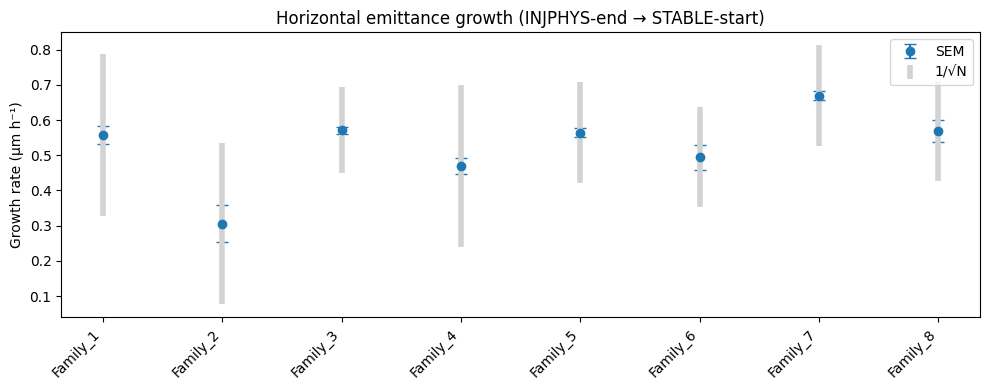

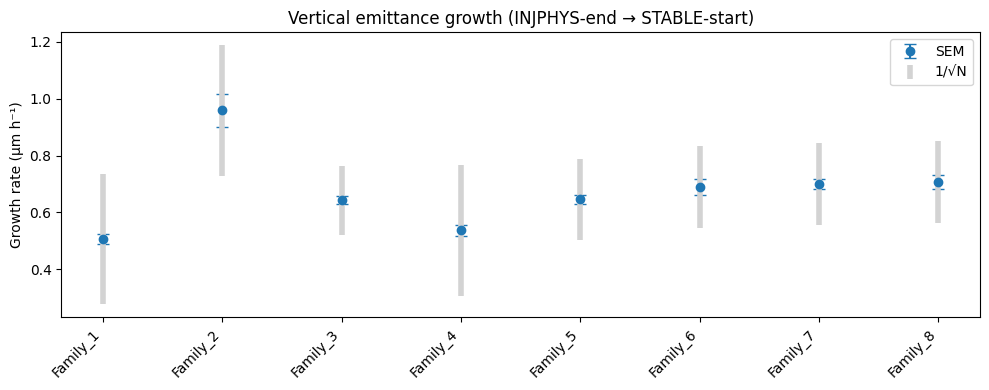

In [ ]:
families_list = df_families_mid.index.tolist()
invroot_h, invroot_v = [], []

for fam in families_list:
    slots = families[fam]
    n_h = sum(1 for s in slots if not np.isnan(per_slot_h_mid[s]))
    n_v = sum(1 for s in slots if not np.isnan(per_slot_v_mid[s]))
    invroot_h.append(1/np.sqrt(n_h) if n_h else np.nan)
    invroot_v.append(1/np.sqrt(n_v) if n_v else np.nan)

x = np.arange(len(families_list))

# ------------------------------------------------------------
# 1) Horizontal plot (INJPHYS-end → STABLE-start)
# ------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.errorbar(x, df_families_mid['H_rate_avg_mid'],
             yerr=df_families_mid['H_rate_sem_mid'],
             fmt='o', capsize=4, label='SEM')
plt.errorbar(x, df_families_mid['H_rate_avg_mid'],
             yerr=invroot_h,
             fmt='none', ecolor='lightgray', elinewidth=4, capsize=0,
             label='1/√N')
plt.xticks(x, families_list, rotation=45, ha='right')
plt.ylabel('Growth rate (µm h⁻¹)')
plt.title('Horizontal emittance growth (INJPHYS-end → STABLE-start)')
plt.legend()
plt.tight_layout()

# ------------------------------------------------------------
# 2) Vertical plot (INJPHYS-end → STABLE-start)
# ------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.errorbar(x, df_families_mid['V_rate_avg_mid'],
             yerr=df_families_mid['V_rate_sem_mid'],
             fmt='o', capsize=4, label='SEM')
plt.errorbar(x, df_families_mid['V_rate_avg_mid'],
             yerr=invroot_v,
             fmt='none', ecolor='lightgray', elinewidth=4, capsize=0,
             label='1/√N')
plt.xticks(x, families_list, rotation=45, ha='right')
plt.ylabel('Growth rate (µm h⁻¹)')
plt.title('Vertical emittance growth (INJPHYS-end → STABLE-start)')
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
from typing import Union   # for Python < 3.10

def show_bmodes_utc(fbmodes: pd.DataFrame, fno: Union[int, str]) -> None:
    """
    Pretty-print the machine BMODE timeline for `fno` in UTC.

    fbmodes : DataFrame indexed by fill number, columns include
              'BMODE', 'tsStart', 'tsEnd' (ns since epoch)
    fno     : fill number (int or str)
    """
    # select the rows for this fill and sort them chronologically
    rows = fbmodes.loc[fno].sort_values("tsStart").copy()

    # convert the nanosecond integers to pandas Timestamps (UTC)
    rows["UTC_start"] = pd.to_datetime(rows["tsStart"], unit="ns", utc=True)
    rows["UTC_end"]   = pd.to_datetime(rows["tsEnd"],   unit="ns", utc=True)

    # choose columns to display
    out = rows[["BMODE", "UTC_start", "UTC_end"]]

    # nice formatting
    print(f"\n=== Fill {fno}: machine phases in UTC ===")
    print(out.to_string(
        index=False,
        formatters={
            "UTC_start": lambda x: x.strftime("%Y-%m-%d %H:%M:%S"),
            "UTC_end":   lambda x: x.strftime("%Y-%m-%d %H:%M:%S")
        }
    ))
show_bmodes_utc(fbmodes, fno)


=== Fill 10709: machine phases in UTC ===
   BMODE           UTC_start             UTC_end
    FILL 2025-06-11 01:36:04 2025-06-12 11:15:00
RAMPDOWN 2025-06-11 01:36:04 2025-06-11 01:56:37
   SETUP 2025-06-11 01:56:37 2025-06-11 02:56:35
 INJPROB 2025-06-11 02:56:35 2025-06-11 03:05:49
 INJPHYS 2025-06-11 03:05:49 2025-06-11 03:40:19
 PRERAMP 2025-06-11 03:40:19 2025-06-11 03:41:53
    RAMP 2025-06-11 03:41:53 2025-06-11 04:03:17
 FLATTOP 2025-06-11 04:03:17 2025-06-11 04:03:34
 SQUEEZE 2025-06-11 04:03:34 2025-06-11 04:22:00
  ADJUST 2025-06-11 04:22:00 2025-06-11 04:30:19
  STABLE 2025-06-11 04:30:19 2025-06-12 11:02:15
BEAMDUMP 2025-06-12 11:02:15 2025-06-12 11:02:40
BEAMDUMP 2025-06-12 11:02:40 2025-06-12 11:02:42
RAMPDOWN 2025-06-12 11:02:42 2025-06-12 11:15:00


# ALL

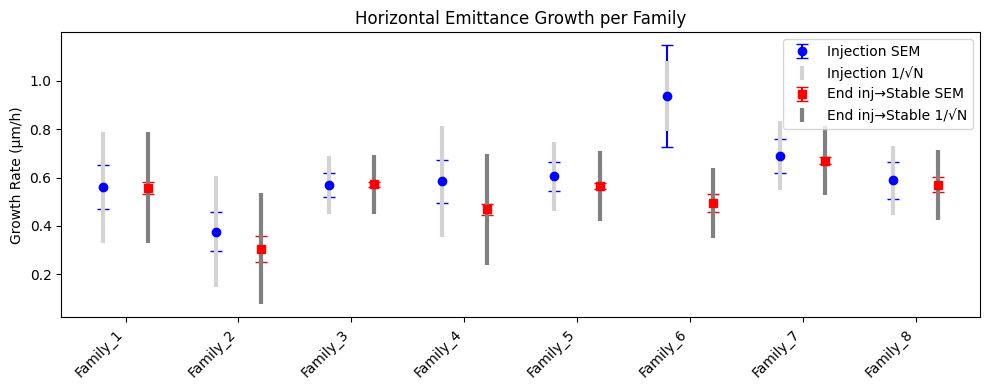

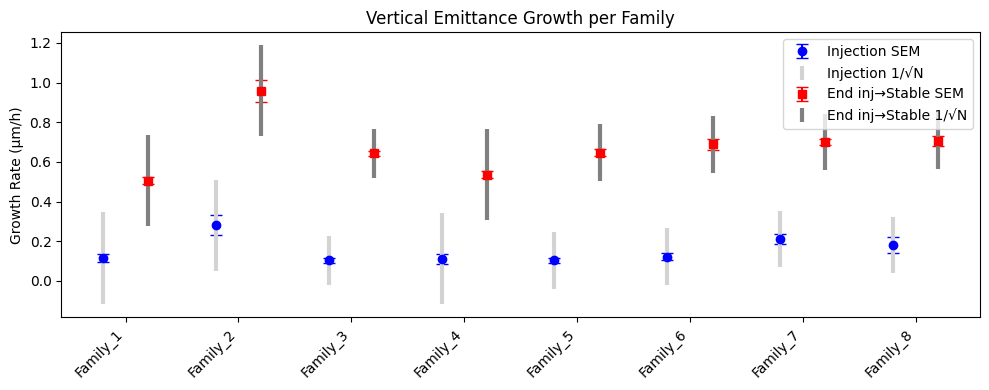

In [ ]:
families_list = list(families.keys())
x = np.arange(len(families_list))
width = 0.2

# Injection: counts & 1/√N
counts_h_inj = np.array([
    len([s for s in families[fam] if not np.isnan(per_slot_h.get(s, np.nan))])
    for fam in families_list
])
counts_v_inj = np.array([
    len([s for s in families[fam] if not np.isnan(per_slot_v.get(s, np.nan))])
    for fam in families_list
])
inv_sqrtN_h_inj = 1 / np.sqrt(counts_h_inj, where=counts_h_inj>0)
inv_sqrtN_v_inj = 1 / np.sqrt(counts_v_inj, where=counts_v_inj>0)

# Mid-window: counts & 1/√N
counts_h_mid = np.array([
    len([s for s in families[fam] if not np.isnan(per_slot_h_mid.get(s, np.nan))])
    for fam in families_list
])
counts_v_mid = np.array([
    len([s for s in families[fam] if not np.isnan(per_slot_v_mid.get(s, np.nan))])
    for fam in families_list
])
inv_sqrtN_h_mid = 1 / np.sqrt(counts_h_mid, where=counts_h_mid>0)
inv_sqrtN_v_mid = 1 / np.sqrt(counts_v_mid, where=counts_v_mid>0)

# ───────────────────────────────────────────
# Horizontal Emittance Growth
# ───────────────────────────────────────────
plt.figure(figsize=(10,4))

# Injection: SEM
plt.errorbar(
    x - width,
    df_family_inj.loc[families_list, 'H_rate_avg'],
    yerr=df_family_inj.loc[families_list, 'H_sem'],
    fmt='o', capsize=4, label='Injection SEM', color='blue'
)
# Injection: 1/√N
plt.errorbar(
    x - width,
    df_family_inj.loc[families_list, 'H_rate_avg'],
    yerr=inv_sqrtN_h_inj,
    fmt='none', ecolor='lightgray', elinewidth=3, capsize=0,
    label='Injection 1/√N'
)

# Mid-window: SEM
plt.errorbar(
    x + width,
    df_families_mid.loc[families_list, 'H_rate_avg_mid'],
    yerr=df_families_mid.loc[families_list, 'H_rate_sem_mid'],
    fmt='s', capsize=4, label='End inj→Stable SEM', color='red'
)
# Mid-window: 1/√N
plt.errorbar(
    x + width,
    df_families_mid.loc[families_list, 'H_rate_avg_mid'],
    yerr=inv_sqrtN_h_mid,
    fmt='none', ecolor='gray', elinewidth=3, capsize=0,
    label='End inj→Stable 1/√N'
)

plt.xticks(x, families_list, rotation=45, ha='right')
plt.title('Horizontal Emittance Growth per Family')
plt.ylabel('Growth Rate (µm/h)')
plt.legend()
plt.tight_layout()

# ───────────────────────────────────────────
# Vertical Emittance Growth
# ───────────────────────────────────────────
plt.figure(figsize=(10,4))

# Injection: SEM
plt.errorbar(
    x - width,
    df_family_inj.loc[families_list, 'V_rate_avg'],
    yerr=df_family_inj.loc[families_list, 'V_sem'],
    fmt='o', capsize=4, label='Injection SEM', color='blue'
)
# Injection: 1/√N
plt.errorbar(
    x - width,
    df_family_inj.loc[families_list, 'V_rate_avg'],
    yerr=inv_sqrtN_v_inj,
    fmt='none', ecolor='lightgray', elinewidth=3, capsize=0,
    label='Injection 1/√N'
)

# Mid-window: SEM
plt.errorbar(
    x + width,
    df_families_mid.loc[families_list, 'V_rate_avg_mid'],
    yerr=df_families_mid.loc[families_list, 'V_rate_sem_mid'],
    fmt='s', capsize=4, label='End inj→Stable SEM', color='red'
)
# Mid-window: 1/√N
plt.errorbar(
    x + width,
    df_families_mid.loc[families_list, 'V_rate_avg_mid'],
    yerr=inv_sqrtN_v_mid,
    fmt='none', ecolor='gray', elinewidth=3, capsize=0,
    label='End inj→Stable 1/√N'
)

plt.xticks(x, families_list, rotation=45, ha='right')
plt.title('Vertical Emittance Growth per Family')
plt.ylabel('Growth Rate (µm/h)')
plt.legend()
plt.tight_layout()

plt.show()

# STABLE

/tmp/ipykernel_2350876/306030733.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return full[pv_name].loc[t0:t1].resample('1S').mean().dropna()
/tmp/ipykernel_2350876/306030733.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return full[pv_name].loc[t0:t1].resample('1S').mean().dropna()
/tmp/ipykernel_2350876/306030733.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return full[pv_name].loc[t0:t1].resample('1S').mean().dropna()


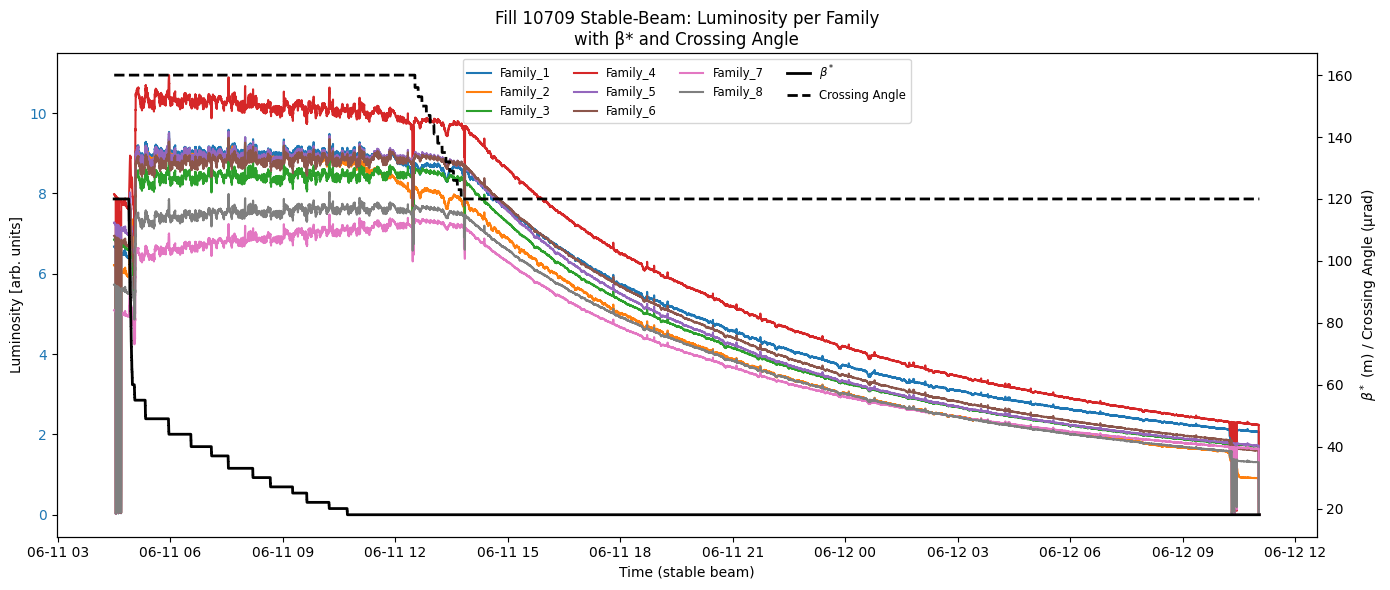

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── CONFIG ────────────────────────────────────────────────────────
DATADIR      = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/')
RAWDATA_DIR  = DATADIR / 'rawdata'
FILLINFO_DIR = DATADIR / "fills-info"

# PV names
LUMI_PV = 'CMS:BUNCH_LUMI_INST'  # replace with your actual lumi PV
BETA_PV = 'HX:BETASTAR_IP1'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'

# families: dict mapping family_name → list of slots
# fbmodes: DataFrame with a MultiIndex (fill_no) and columns ['tsStart','tsEnd','BMODE']
#    loaded elsewhere in your script
# ────────────────────────────────────────────────────────────────────

def load_STABLE_series(pv_name: str, fno: int) -> pd.Series:
    """
    Load PV over the STABLE interval for fill `fno`:
    from first STABLE tsStart to last STABLE tsEnd, resampled to 1 s.
    """
    sub = fbmodes.loc[fno].sort_values('tsStart')
    stable = sub[sub['BMODE'].str.upper()=='STABLE']
    if stable.empty:
        raise RuntimeError(f"No STABLE period for fill {fno}")
    t0 = pd.to_datetime(stable['tsStart'].iloc[0], unit='ns', utc=True)
    t1 = pd.to_datetime(stable['tsEnd'].iloc[-1],   unit='ns', utc=True)

    # gather all parquet shards under this fill
    parts = []
    pq_dir = RAWATA_DIR = RAWDATA_DIR / f"HX:FILLN={fno}"
    for pq in pq_dir.rglob('*.parquet'):
        try:
            df = pd.read_parquet(pq, columns=[pv_name])
        except Exception:
            continue
        df.index = pd.to_datetime(df.index, unit='ns', utc=True)
        parts.append(df[[pv_name]].dropna())
    if not parts:
        raise RuntimeError(f"No data for PV {pv_name} in fill {fno}")
    full = pd.concat(parts).sort_index()
    full = full[~full.index.duplicated(keep='first')]

    return full[pv_name].loc[t0:t1].resample('1S').mean().dropna()

def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    """
    Given a Series whose values are array-like per slot,
    return the slot-th element as a float time series.
    """
    return ser.apply(
        lambda arr:
            arr[slot]
            if hasattr(arr, '__len__') and len(arr) > slot
            else np.nan
    ).dropna()


# ─── 2) load stable-beam series ────────────────────────────────────────
ser_lumi = load_STABLE_series(LUMI_PV, fno)   # values are arrays per slot
ser_beta = load_STABLE_series(BETA_PV, fno)   # scalar per time
ser_xing = load_STABLE_series(XING_PV, fno)   # scalar per time

# ─── 3) compute per-family luminosity time series ────────────────────
family_lumi_ts = {}
for fam, slots in families.items():
    # build a small DataFrame of shape (time × len(slots))
    df_slots = pd.concat(
        [ extract_slot(ser_lumi, slot).rename(slot)
          for slot in slots ],
        axis=1
    )
    # average across slots for this family
    family_lumi_ts[fam] = df_slots.mean(axis=1)

df_family_lumi_ts = pd.DataFrame(family_lumi_ts)

# ─── 4) plot all eight family curves + β* and crossing angle ─────────
fig, axL = plt.subplots(figsize=(14, 6))

# left y-axis: luminosity curves
for fam in df_family_lumi_ts.columns:
    axL.plot(df_family_lumi_ts.index,
             df_family_lumi_ts[fam],
             label=fam, linewidth=1.5)
axL.set_ylabel('Luminosity [arb. units]')
axL.set_xlabel('Time (stable beam)')
axL.tick_params(axis='y', labelcolor='C0')

# right y-axis: β* and crossing-angle
axR = axL.twinx()
axR.plot(ser_beta.index, ser_beta, 'k-', lw=2, label=r'$\beta^*$')
axR.plot(ser_xing.index, ser_xing, 'k--', lw=2, label='Crossing Angle')
axR.set_ylabel(r'$\beta^*$ (m) / Crossing Angle (μrad)')
axR.tick_params(axis='y', labelcolor='k')

# legends
lines_L, labels_L = axL.get_legend_handles_labels()
lines_R, labels_R = axR.get_legend_handles_labels()
axL.legend(lines_L + lines_R,
           labels_L + labels_R,
           loc='upper center',
           ncol=4,
           fontsize='small')

plt.title(f'Fill {fno} Stable-Beam: Luminosity per Family\nwith β* and Crossing Angle')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# — assume ser_beta and ser_xing are already your utc-indexed pd.Series —

# 1) Find the “stable” plateau in β* (longest constant run)
runs = []
t_prev, v_prev = ser_beta.index[0], ser_beta.iloc[0]
t_run_start = t_prev

for t, v in ser_beta.iloc[1:].items():
    if v != v_prev:
        # close out previous run
        runs.append((v_prev, t_run_start, t_prev))
        t_run_start, v_prev = t, v
    t_prev = t
# final run
runs.append((v_prev, t_run_start, t_prev))

# pick the longest run
runs_with_dur = [(val, t0, t1, t1 - t0) for val,t0,t1 in runs]
val_long, t_long_start, t_long_end, dur_long = max(runs_with_dur, key=lambda x: x[3])

print(f"β* drops into its final value of {val_long:.3f} m at {t_long_start:%Y-%m-%d %H:%M:%S} UTC")
print(f"  and then stays constant for {dur_long}")

# 2) Find when crossing‐angle first leaves ~160 µrad
#    (we take initial plateau as the value at t0)
xing0 = ser_xing.iloc[0]
# find first index where it differs
mask_change = ser_xing != xing0
t_xing_leave = ser_xing.index[mask_change.argmax()]  if mask_change.any() else None

# 3) Find first time it dips below 120 µrad
mask_120 = ser_xing <= 120
t_xing_120 = ser_xing.index[mask_120.argmax()]   if mask_120.any() else None

print(f"Crossing angle starts to change from {xing0:.0f} µrad at {t_xing_leave:%Y-%m-%d %H:%M:%S} UTC")
print(f"Crossing angle drops to ≲120 µrad at   {t_xing_120:%Y-%m-%d %H:%M:%S} UTC")


β* drops into its final value of 18.000 m at 2025-06-11 10:43:17 UTC
  and then stays constant for 1 days 00:18:58
Crossing angle starts to change from 160 µrad at 2025-06-11 12:31:28 UTC
Crossing angle drops to ≲120 µrad at   2025-06-11 13:45:26 UTC


### 2 point method

In [ ]:
import numpy as np
import pandas as pd
import pathlib
from scipy.stats import linregress  # imported in case you want later comparisons
emitH_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_H"
emitV_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_V"
# -----------------------------------------------------------------------
# Forward-looking 5-min bin: label = *start* of interval (t, t+5m]
# -----------------------------------------------------------------------
def bin5_forward(ser: pd.Series) -> pd.Series:
    if ser.empty:
        return ser
    b = ser.resample("5min", closed="right", label="right").mean()
    b.index = b.index - pd.Timedelta(minutes=5)  # move label to left edge
    return b


# -----------------------------------------------------------------------
# Load a PV from all parquet parts -> UTC Series
# -----------------------------------------------------------------------
def load_series(var: str) -> pd.Series:
    root = RAWDATA / f"HX:FILLN={fno}"
    parts = []
    for pq in pathlib.Path(root).rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[var])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        ser = pd.Series(df[var].to_numpy(), index=idx, name=var)
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float, name=var)
    return pd.concat(parts).sort_index()


# -----------------------------------------------------------------------
# Derive phase markers from β* & crossing-angle traces
# -----------------------------------------------------------------------
def phase_markers_from_beta_xing(ser_beta: pd.Series,
                                 ser_xing: pd.Series,
                                 xing_threshold=120):
    # longest constant β* run
    runs = []
    t_prev = ser_beta.index[0]
    v_prev = ser_beta.iloc[0]
    t_run_start = t_prev
    for t, v in ser_beta.iloc[1:].items():
        if v != v_prev:
            runs.append((v_prev, t_run_start, t_prev))
            t_run_start, v_prev = t, v
        t_prev = t
    runs.append((v_prev, t_run_start, t_prev))
    val_long, t_long_start, t_long_end, _ = max(
        ((val, t0, t1, t1 - t0) for (val, t0, t1) in runs),
        key=lambda x: x[3]
    )
    t_beta_final = t_long_start

    # first leave of initial CA
    xing0 = ser_xing.iloc[0]
    mask_change = ser_xing != xing0
    t_xing_begin = ser_xing.index[mask_change.argmax()] if mask_change.any() else ser_xing.index[-1]

    # first dip <= threshold
    mask_thr = ser_xing <= xing_threshold
    t_xing_end = ser_xing.index[mask_thr.argmax()] if mask_thr.any() else ser_xing.index[-1]

    return t_beta_final, t_xing_begin, t_xing_end


# -----------------------------------------------------------------------
# Phase markers (auto)
# -----------------------------------------------------------------------
t_beta_final, t_xing_begin, t_xing_end = phase_markers_from_beta_xing(ser_beta, ser_xing)
print("t_beta_final :", t_beta_final)
print("t_xing_begin :", t_xing_begin)
print("t_xing_end   :", t_xing_end)


# -----------------------------------------------------------------------
# Levelling-on (PV rising edge)
# -----------------------------------------------------------------------
lev_pv = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
ser_lev = load_series(lev_pv)
dlev = ser_lev.diff().fillna(0)
t_on = dlev[dlev > 0].index.min()
if pd.isna(t_on):
    nz = ser_lev[ser_lev > 0]
    t_on = nz.index.min() if not nz.empty else ser_lev.index.min()
print("Levelling on @", t_on)

# *** strict after-levelling anchor ***
t_on_bin = t_on.ceil("5min")
print("Requested anchor tick (ceil to 5min) =", t_on_bin)


# -----------------------------------------------------------------------
# Load emittance array PVs
# -----------------------------------------------------------------------
ser_H = load_series(emitH_var)
ser_V = load_series(emitV_var)
if ser_H.empty and ser_V.empty:
    raise RuntimeError("No emittance data found.")


# -----------------------------------------------------------------------
# Master 5-min grid (full emittance coverage through CA end)
# -----------------------------------------------------------------------
master_start = min(
    ts for ts in [ser_H.index.min(), ser_V.index.min()] if pd.notna(ts)
).floor("5min")
master_end = t_xing_end.ceil("5min")
master_idx = pd.date_range(master_start, master_end, freq="5min", tz="UTC")


# -----------------------------------------------------------------------
# Extract one scalar slot from array-valued sample
# -----------------------------------------------------------------------
def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    return ser.apply(lambda a: a[slot] if hasattr(a, "__len__") and len(a) > slot else np.nan)


# -----------------------------------------------------------------------
# Build per-slot *binned* (no ffill) Series dictionaries
# -----------------------------------------------------------------------
h5_dict = {}
v5_dict = {}
for fam, slots in families.items():
    for s in slots:
        h_raw = extract_slot(ser_H, s).dropna().sort_index()
        v_raw = extract_slot(ser_V, s).dropna().sort_index()
        if h_raw.empty and v_raw.empty:
            continue

        h_b5 = bin5_forward(h_raw)
        v_b5 = bin5_forward(v_raw)

        # align to master grid *without* filling; this preserves only true 5-min means
        h5 = h_b5.reindex(master_idx)
        v5 = v_b5.reindex(master_idx)

        h5_dict[s] = h5
        v5_dict[s] = v5


# -----------------------------------------------------------------------
# Determine **effective** analysis anchor:
#   first master tick >= t_on_bin with at least one *real* data value
# -----------------------------------------------------------------------
df_all_slots = pd.concat(
    [s for s in h5_dict.values()] + [s for s in v5_dict.values()],
    axis=1
) if (h5_dict or v5_dict) else pd.DataFrame(index=master_idx)

# restrict to >= requested anchor
df_after = df_all_slots.loc[t_on_bin:]
valid_mask = ~df_after.isna().all(axis=1)
if not valid_mask.any():
    raise RuntimeError("No 5-min binned emittance data at/after levelling anchor.")
t_on_bin_eff = valid_mask.index[valid_mask.argmax()]  # first True row
print("Effective anchor tick (data-supported) =", t_on_bin_eff)


# -----------------------------------------------------------------------
# Build windows (levelling → β* final → CA start → CA end)
# NOTE: windows use *original* levelling timestamp t_on (not binned),
#       but cumulative calc always starts at t_on_bin_eff.
# -----------------------------------------------------------------------
windows = []
prev = t_on
hour = 1

# hourly bins up to β* final
for mark in pd.date_range(prev + pd.Timedelta(hours=1), t_beta_final, freq="1h"):
    windows.append((f"{hour} h since lvl-on", prev, mark))
    prev = mark
    hour += 1

if prev < t_beta_final:
    windows.append(("to β* final", prev, t_beta_final))
    prev = t_beta_final

if prev < t_xing_begin:
    windows.append(("β*→CA start", prev, t_xing_begin))
    prev = t_xing_begin

if prev < t_xing_end:
    windows.append(("CA start→end", prev, t_xing_end))


# -----------------------------------------------------------------------
# Endpoint rates (cumulative) from t_on_bin_eff → window end
#   using *only* 5-min bin means (no ffill)
#   slot-level → family mean; SEM across slots
# -----------------------------------------------------------------------
tol = pd.Timedelta(minutes=5)  # allow slot to start within 1 bin of anchor

rows = []
for entry in windows:
    label, _t0, t1_orig = entry[:3]
    t1 = t1_orig if isinstance(t1_orig, pd.Timestamp) else pd.to_datetime(t1_orig, utc=True)

    t1_bin = t1.ceil("5min")
    if t1_bin > master_end:
        t1_bin = master_end

    dt_h = (t1_bin - t_on_bin_eff).total_seconds() / 3600.0
    if dt_h <= 0:
        continue

    row = {"window": label}

    for fam, slots in families.items():
        rh, rv = [], []

        for s in slots:
            h5 = h5_dict.get(s)
            v5 = v5_dict.get(s)

            # --- Horizontal slot
            if h5 is not None:
                hh = h5.loc[t_on_bin_eff:t1_bin].dropna()
                if not hh.empty and (hh.index[0] - t_on_bin_eff) <= tol:
                    rh.append((hh.iloc[-1] - hh.iloc[0]) / dt_h)

            # --- Vertical slot
            if v5 is not None:
                vv = v5.loc[t_on_bin_eff:t1_bin].dropna()
                if not vv.empty and (vv.index[0] - t_on_bin_eff) <= tol:
                    rv.append((vv.iloc[-1] - vv.iloc[0]) / dt_h)

        row[f"{fam}_H_rate"] = np.nanmean(rh) if rh else np.nan
        row[f"{fam}_H_sem"]  = (np.std(rh, ddof=1) / np.sqrt(len(rh))) if len(rh) > 1 else np.nan
        row[f"{fam}_V_rate"] = np.nanmean(rv) if rv else np.nan
        row[f"{fam}_V_sem"]  = (np.std(rv, ddof=1) / np.sqrt(len(rv))) if len(rv) > 1 else np.nan

    rows.append(row)

df_rates = pd.DataFrame(rows).set_index("window")
print(df_rates)


t_beta_final : 2025-06-11 10:43:17+00:00
t_xing_begin : 2025-06-11 12:31:28+00:00
t_xing_end   : 2025-06-11 13:45:26+00:00


/tmp/ipykernel_2350876/4078444056.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dlev = ser_lev.diff().fillna(0)


Levelling on @ 2025-06-11 05:04:55.248704+00:00
Requested anchor tick (ceil to 5min) = 2025-06-11 05:05:00+00:00
Effective anchor tick (data-supported) = 2025-06-11 05:05:00+00:00
                  Family_1_H_rate  Family_1_H_sem  Family_1_V_rate  \
window                                                               
1 h since lvl-on         0.118596        0.014523         0.039107   
2 h since lvl-on         0.057620        0.006771         0.017864   
3 h since lvl-on         0.072434        0.005275         0.059386   
4 h since lvl-on         0.040566        0.005942         0.053608   
5 h since lvl-on         0.066996        0.003172         0.046535   
to β* final              0.043732        0.003055         0.044236   
β*→CA start              0.063905        0.002645         0.057896   
CA start→end             0.051092        0.001829         0.054201   

                  Family_1_V_sem  Family_2_H_rate  Family_2_H_sem  \
window                                            

In [ ]:
# -----------------------------------------------------------------------
# Endpoint rates (cumulative) from t_on_bin_eff → window end
#   using *only* 5-min bin means (no ffill)
#   slot-level → family mean; SEM across slots
#   >>> NOW: record which slot IDs contributed (coverage rule applied) <<<
# -----------------------------------------------------------------------
tol = pd.Timedelta(minutes=5)  # allow slot to start within 1 bin of anchor

rows = []
for entry in windows:
    label, _t0, t1_orig = entry[:3]
    t1 = t1_orig if isinstance(t1_orig, pd.Timestamp) else pd.to_datetime(t1_orig, utc=True)

    # snap to 5-min grid & clip
    t1_bin = t1.ceil("5min")
    if t1_bin > master_end:
        t1_bin = master_end

    dt_h = (t1_bin - t_on_bin_eff).total_seconds() / 3600.0
    if dt_h <= 0:
        continue

    row = {"window": label}

    for fam, slots in families.items():
        rh, rv = [], []

        slots_h_used = []  # record accepted horizontal slots
        slots_v_used = []  # record accepted vertical slots

        for s in slots:
            h5 = h5_dict.get(s)
            v5 = v5_dict.get(s)

            # --- Horizontal slot --------------------------------------------------
            if h5 is not None:
                hh = h5.loc[t_on_bin_eff:t1_bin].dropna()
                # accept if we have data AND it starts within tol of anchor
                if not hh.empty and (hh.index[0] - t_on_bin_eff) <= tol:
                    rh.append((hh.iloc[-1] - hh.iloc[0]) / dt_h)
                    slots_h_used.append(s)

            # --- Vertical slot ----------------------------------------------------
            if v5 is not None:
                vv = v5.loc[t_on_bin_eff:t1_bin].dropna()
                if not vv.empty and (vv.index[0] - t_on_bin_eff) <= tol:
                    rv.append((vv.iloc[-1] - vv.iloc[0]) / dt_h)
                    slots_v_used.append(s)

        # family aggregates
        row[f"{fam}_H_rate"] = np.nanmean(rh) if rh else np.nan
        row[f"{fam}_H_sem"]  = (np.std(rh, ddof=1) / np.sqrt(len(rh))) if len(rh) > 1 else np.nan
        row[f"{fam}_H_nSlots_ep"] = len(slots_h_used)
        row[f"{fam}_H_slots_used"] = tuple(slots_h_used)  # store as tuple for readability

        row[f"{fam}_V_rate"] = np.nanmean(rv) if rv else np.nan
        row[f"{fam}_V_sem"]  = (np.std(rv, ddof=1) / np.sqrt(len(rv))) if len(rv) > 1 else np.nan
        row[f"{fam}_V_nSlots_ep"] = len(slots_v_used)
        row[f"{fam}_V_slots_used"] = tuple(slots_v_used)

    rows.append(row)

df_rates = pd.DataFrame(rows).set_index("window")
print(df_rates)


                  Family_1_H_rate  Family_1_H_sem  Family_1_H_nSlots_ep  \
window                                                                    
1 h since lvl-on         0.118596        0.014523                    19   
2 h since lvl-on         0.057620        0.006771                    19   
3 h since lvl-on         0.072434        0.005275                    19   
4 h since lvl-on         0.040566        0.005942                    19   
5 h since lvl-on         0.066996        0.003172                    19   
to β* final              0.043732        0.003055                    19   
β*→CA start              0.063905        0.002645                    19   
CA start→end             0.051092        0.001829                    19   

                                              Family_1_H_slots_used  \
window                                                                
1 h since lvl-on  (55, 208, 404, 600, 796, 949, 1102, 1298, 1494...   
2 h since lvl-on  (55, 208, 404, 600

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_family_rates(df_rates, families, plane="V",
                      ylabel=None, title=None,
                      drop_label="1 h since lvl-on",  # label to exclude
                      ylim_pad_frac=0.05):            # 5% headroom
    """
    Plot per-family growth rates (±SEM) skipping an initial window,
    e.g. the '1 h since lvl-on' point, and auto-zoom the y-axis.

    Parameters
    ----------
    df_rates : DataFrame
        Must contain columns like 'Family_3_V_rate', 'Family_3_V_sem', etc.
        Index = windows (strings).
    families : iterable of str
        Family names used as column prefixes.
    plane : {'H','V','h','v'}
        Which plane to plot.
    ylabel, title : optional str
        Axis labels; auto-generated if None.
    drop_label : str or None
        Window label to exclude. If None, nothing is dropped.
    ylim_pad_frac : float
        Fractional padding added to y-range for zoom.
    """

    # --- choose plane tokens ---
    pl = plane.upper()
    if pl not in ("H", "V"):
        raise ValueError("plane must be 'H' or 'V'")

    # --- choose windows; drop the 1h label if present ---
    if drop_label is not None and drop_label in df_rates.index:
        df_plot = df_rates.drop(index=drop_label)
    else:
        df_plot = df_rates

    windows_ = df_plot.index.to_list()
    x = np.arange(len(windows_))

    # --- labels ---
    if ylabel is None:
        axis_eps = r"$\varepsilon_x$" if pl == "H" else r"$\varepsilon_y$"
        ylabel = f"{axis_eps} growth rate [µm/h]"

    if title is None:
        axis_name = "Horizontal" if pl == "H" else "Vertical"
        title = f"{axis_name} Emittance Growth per Family\n(± SEM over each window)"

    # --- collect all y values (for zoom) while plotting ---
    all_y_vals = []

    plt.figure(figsize=(12, 6))

    for fam in families:
        rate_col = f"{fam}_{pl}_rate"
        sem_col  = f"{fam}_{pl}_sem"

        if rate_col not in df_plot.columns:
            print(f"Skipping {fam}: missing column {rate_col!r}.")
            continue
        if sem_col not in df_plot.columns:
            print(f"Skipping {fam}: missing column {sem_col!r}.")
            continue

        y    = df_plot[rate_col].values.astype(float)
        yerr = df_plot[sem_col].values.astype(float)

        # Skip if *all* NaN
        if np.all(np.isnan(y)):
            print(f"Skipping {fam}: all NaN in {rate_col}.")
            continue

        plt.errorbar(
            x, y, yerr=yerr,
            fmt="s", linestyle="None", capsize=4, label=fam
        )

        # accumulate finite values for zoom
        good = np.isfinite(y)
        if good.any():
            all_y_vals.append(y[good])
            # include errorbars in zoom consideration if available
            if np.isfinite(yerr).any():
                # take absolute err; guard shape mismatch
                yerr_good = np.where(good, np.nan_to_num(yerr, nan=0.0), 0.0)
                all_y_vals.append((y + yerr_good)[good])
                all_y_vals.append((y - yerr_good)[good])

    plt.xticks(x, windows_, rotation=45, ha="right")
    plt.xlabel("Analysis window")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(ncol=2, fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")

    # --- auto-zoom y-axis ---
    if all_y_vals:
        concat = np.concatenate(all_y_vals)
        ymin = np.nanmin(concat)
        ymax = np.nanmax(concat)
        if np.isfinite(ymin) and np.isfinite(ymax):
            if ymin == ymax:
                # degenerate: add tiny pad
                pad = abs(ymax) * ylim_pad_frac if ymax != 0 else 0.1
                plt.ylim(ymin - pad, ymax + pad)
            else:
                yrng = ymax - ymin
                pad = yrng * ylim_pad_frac
                plt.ylim(ymin - pad, ymax + pad)

    plt.tight_layout()
    plt.show()


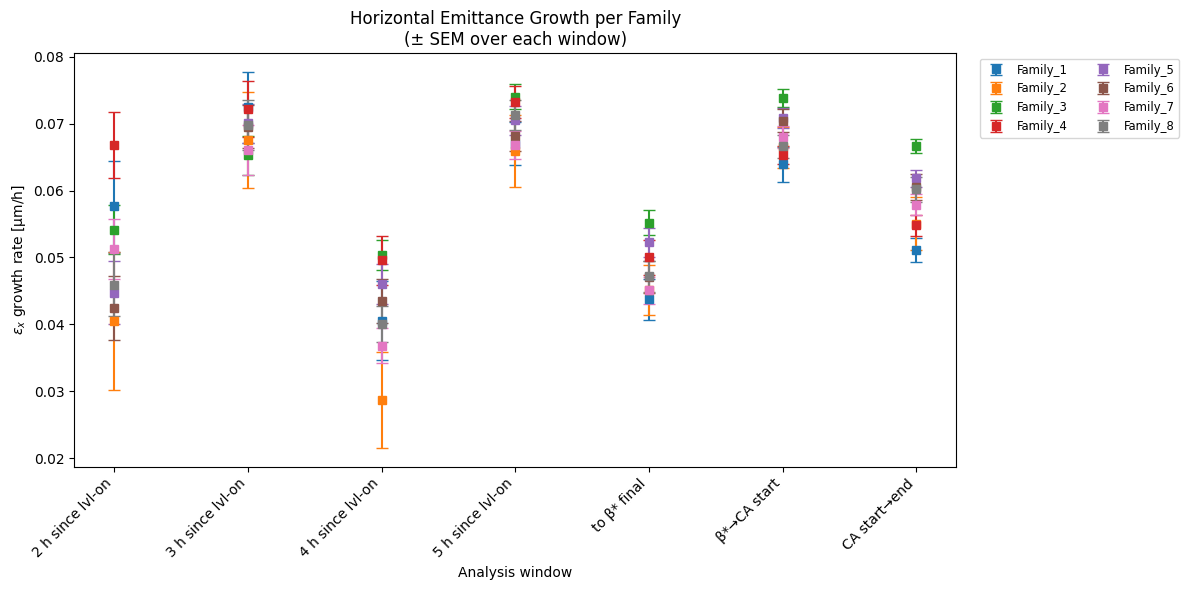

In [ ]:
plot_family_rates(df_rates, families=families, plane="H")


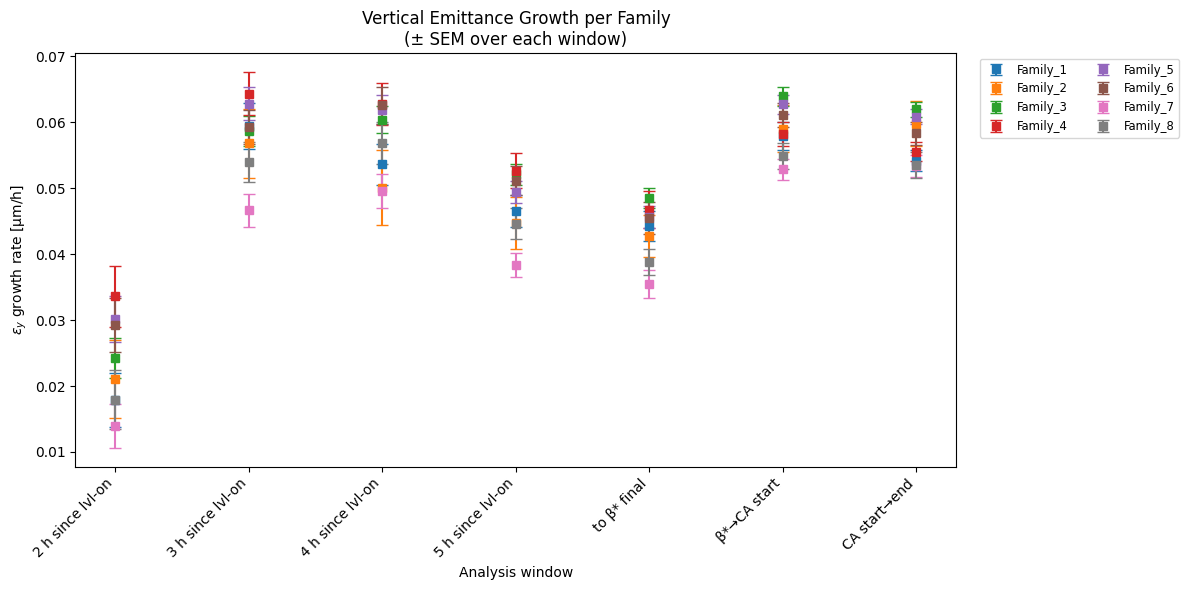

In [ ]:
plot_family_rates(df_rates, families=families, plane="V")

In [ ]:
print("Levelling raw:", t_on)
print("Levelling bin (ceil 5m):", t_on_bin)
print("Levelling effective (data-supported):", t_on_bin_eff)


Levelling raw: 2025-06-11 05:04:55.248704+00:00
Levelling bin (ceil 5m): 2025-06-11 05:05:00+00:00
Levelling effective (data-supported): 2025-06-11 05:05:00+00:00


In [ ]:
tol = pd.Timedelta(minutes=5)  # same as used in your endpoint code

for fam, slots in families.items():
    n_keep_H = 0
    n_keep_V = 0
    for s in slots:
        h5 = h5_dict.get(s)
        if h5 is not None:
            seg = h5.loc[t_on_bin_eff:].dropna()
            if not seg.empty and (seg.index[0] - t_on_bin_eff) <= tol:
                n_keep_H += 1
        v5 = v5_dict.get(s)
        if v5 is not None:
            seg = v5.loc[t_on_bin_eff:].dropna()
            if not seg.empty and (seg.index[0] - t_on_bin_eff) <= tol:
                n_keep_V += 1
    print(f"{fam}: keep_H={n_keep_H}, keep_V={n_keep_V}, total={len(slots)}")


Family_1: keep_H=19, keep_V=19, total=19
Family_2: keep_H=19, keep_V=19, total=19
Family_3: keep_H=68, keep_V=68, total=68
Family_4: keep_H=19, keep_V=19, total=19
Family_5: keep_H=49, keep_V=49, total=49
Family_6: keep_H=49, keep_V=49, total=49
Family_7: keep_H=49, keep_V=49, total=49
Family_8: keep_H=49, keep_V=49, total=49


In [ ]:
def fam_anchor_snapshot(dict5, families, t0):
    out = {}
    for fam, slots in families.items():
        vals = []
        for s in slots:
            ser = dict5.get(s)
            if ser is None: 
                continue
            if t0 in ser.index and not pd.isna(ser.loc[t0]):
                vals.append(ser.loc[t0])
        out[fam] = np.nanmedian(vals) if vals else np.nan
    return pd.Series(out)

print("B? horizontal @ anchor:")
print(fam_anchor_snapshot(h5_dict, families, t_on_bin_eff))
print("B? vertical @ anchor:")
print(fam_anchor_snapshot(v5_dict, families, t_on_bin_eff))


B? horizontal @ anchor:
Family_1    1.923598
Family_2    2.178852
Family_3    1.862750
Family_4    1.853768
Family_5    1.888945
Family_6    1.880476
Family_7    2.040677
Family_8    1.980095
dtype: float64
B? vertical @ anchor:
Family_1    1.669121
Family_2    1.968087
Family_3    1.651699
Family_4    1.638637
Family_5    1.655816
Family_6    1.643496
Family_7    1.805201
Family_8    1.759993
dtype: float64


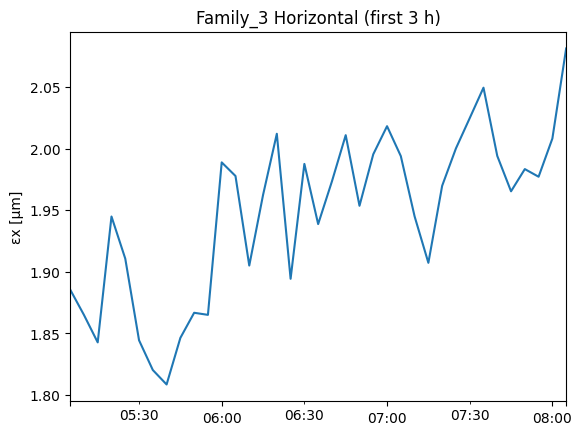

In [ ]:
fam = "Family_3"  # pick any
df_slots = pd.concat([h5_dict[s] for s in families[fam] if s in h5_dict], axis=1)
fam_mean = df_slots.mean(axis=1, skipna=True)
ax = fam_mean.loc[t_on_bin_eff : t_on_bin_eff + pd.Timedelta('3h')].plot()
ax.axvline(t_on, ls='--', c='k', alpha=.5)
ax.set_ylabel("εx [µm]")
ax.set_title(f"{fam} Horizontal (first 3 h)")
plt.show()


# Losses


Family loss dataframe shape: (404, 8)


,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8
2025-06-11 01:35:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-11 01:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-11 01:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-11 01:50:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-11 01:55:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


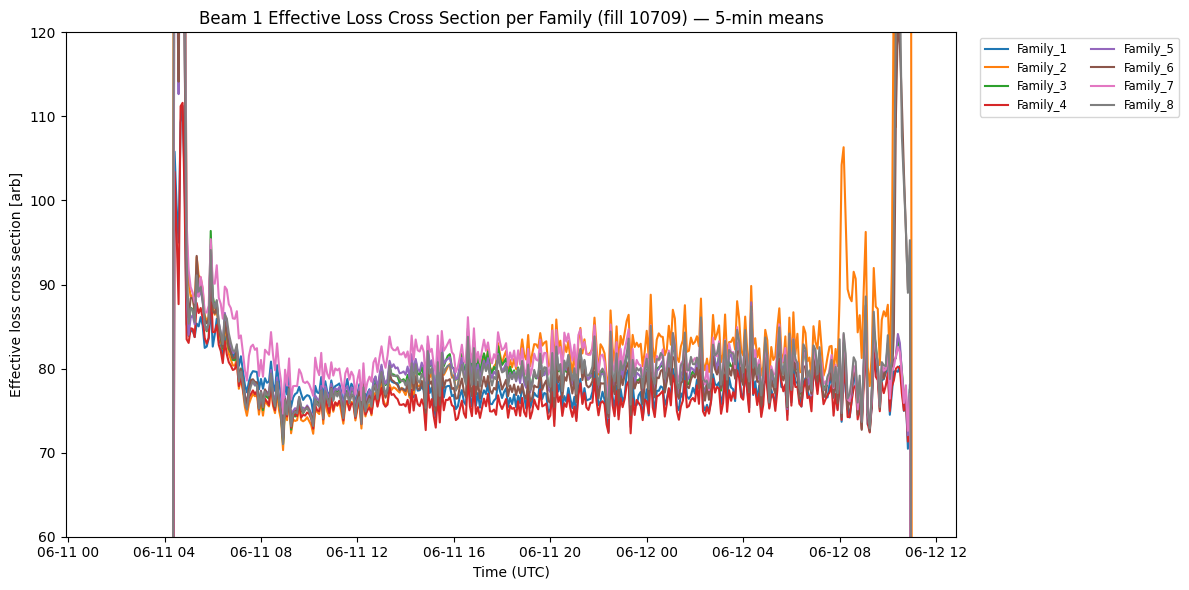

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
RAWDATA = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata')
fno = 10709
# --------------------------------------------------------------------------------
# Config
# --------------------------------------------------------------------------------
loss_b1_var = 'UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB1'
DO_BIN5 = True  # set False to plot raw samples

# --------------------------------------------------------------------------------
# Helpers (comment out if already defined in your notebook)
# --------------------------------------------------------------------------------
def bin5_forward(ser: pd.Series) -> pd.Series:
    """Forward-looking 5-min bin: label = left edge of (t, t+5m] interval."""
    if ser.empty:
        return ser
    b = ser.resample("5min", closed="right", label="right").mean()
    b.index = b.index - pd.Timedelta(minutes=5)
    return b

def load_series(var: str, RAWDATA: Path, fillno: int) -> pd.Series:
    """Concatenate a PV from all parquet chunks in a fill → UTC-indexed Series."""
    root = RAWDATA / f"HX:FILLN={fillno}"
    parts = []
    for pq in root.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[var])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        ser = pd.Series(df[var].to_numpy(), index=idx, name=var)
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float, name=var)
    return pd.concat(parts).sort_index()

def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    """Extract scalar time series for a given bunch slot from an array-valued PV Series."""
    if ser.empty:
        return pd.Series(dtype=float, name=f"slot_{slot}")
    out = ser.apply(lambda a: a[slot] if hasattr(a, "__len__") and len(a) > slot else np.nan)
    out.name = f"slot_{slot}"
    return out

# --------------------------------------------------------------------------------
# Load the loss cross section series (array per timestamp)
# --------------------------------------------------------------------------------
ser_loss = load_series(loss_b1_var, RAWDATA=RAWDATA, fillno=fno)
if ser_loss.empty:
    raise RuntimeError(f"No data found for {loss_b1_var} in fill {fno}.")

# --------------------------------------------------------------------------------
# Build per-family mean time series
# --------------------------------------------------------------------------------
fam_loss_dict = {}

for fam_name, slots in families.items():
    slot_series = []
    for s in np.atleast_1d(slots):
        ss = extract_slot(ser_loss, int(s)).dropna()
        if ss.empty:
            continue
        slot_series.append(ss)

    if not slot_series:
        fam_loss = pd.Series(dtype=float, name=fam_name)
    else:
        # align on union of all timestamps and average rowwise
        df_slots = pd.concat(slot_series, axis=1)
        fam_loss = df_slots.mean(axis=1, skipna=True)
        fam_loss.name = fam_name

    # optional 5-min bin
    if DO_BIN5:
        fam_loss = bin5_forward(fam_loss)

    fam_loss_dict[fam_name] = fam_loss

# --------------------------------------------------------------------------------
# Align all family means on their union time grid
# --------------------------------------------------------------------------------
df_fam_loss = pd.concat(fam_loss_dict, axis=1)  # MultiIndex columns (fam_name)
# flatten columns to plain names
df_fam_loss.columns = df_fam_loss.columns.get_level_values(0)

# Drop rows that are all NaN (no family had data)
df_fam_loss = df_fam_loss.dropna(how="all")

print("Family loss dataframe shape:", df_fam_loss.shape)
display(df_fam_loss.head())

# --------------------------------------------------------------------------------
# Plot
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
for fam_name in df_fam_loss.columns:
    plt.plot(df_fam_loss.index, df_fam_loss[fam_name], label=fam_name)
plt.ylim(60,120)
plt.xlabel("Time (UTC)")
plt.ylabel("Effective loss cross section [arb]")
plt.title(f"Beam 1 Effective Loss Cross Section per Family (fill {fno})"
          + (" — 5-min means" if DO_BIN5 else " — raw samples"))
plt.legend(ncol=2, fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Intensity

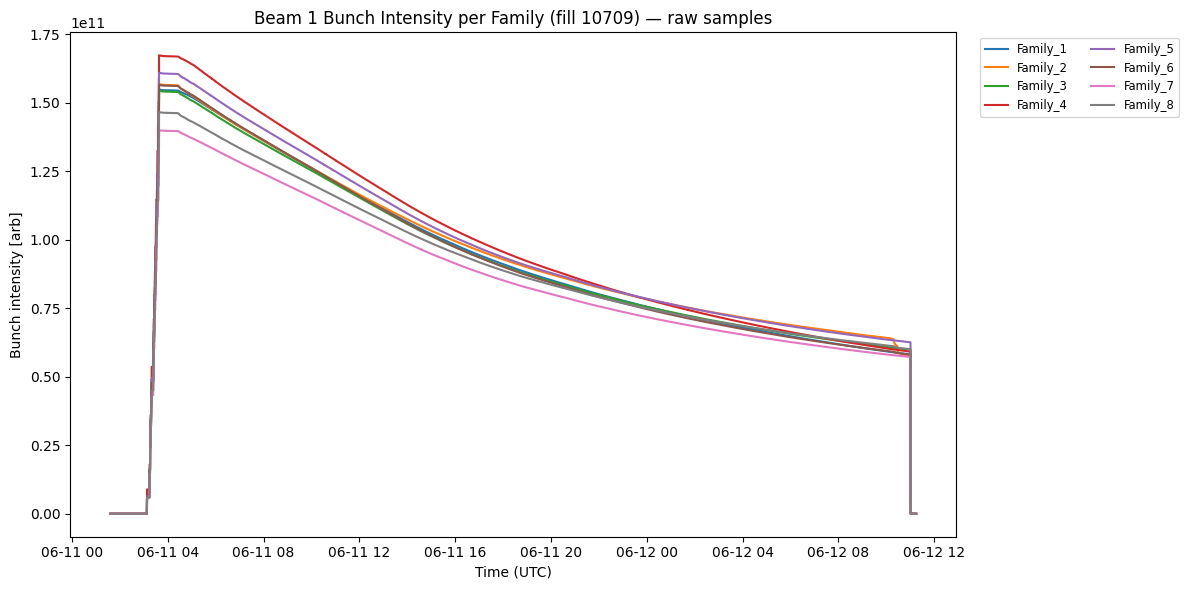

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------------------------
# Config for intensity only
# --------------------------------------------------------------------------------
RAWDATA  = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata')
fno      = 10709
DO_BIN5  = False  # set False to plot raw samples
int_var  = 'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'

# families dict must already be defined:
# families = {
#     "Family_1": Family_1,
#     ...
#     "Family_8": Family_8,
# }

# --------------------------------------------------------------------------------
# Helpers
# --------------------------------------------------------------------------------
def bin5_forward(ser: pd.Series) -> pd.Series:
    if ser.empty:
        return ser
    b = ser.resample("5min", closed="right", label="right").mean()
    b.index = b.index - pd.Timedelta(minutes=5)
    return b

def load_series(var: str, RAWDATA: Path, fillno: int) -> pd.Series:
    root = RAWDATA / f"HX:FILLN={fillno}"
    parts = []
    for pq_path in root.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq_path, columns=[var])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        ser = pd.Series(df[var].to_numpy(), index=idx, name=var)
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float, name=var)
    return pd.concat(parts).sort_index()

def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    if ser.empty:
        return pd.Series(dtype=float, name=f"slot_{slot}")
    out = ser.apply(lambda a: a[slot] if hasattr(a, "__len__") and len(a) > slot else np.nan)
    out.name = f"slot_{slot}"
    return out.dropna()

def build_family_mean(ser: pd.Series, families: dict, do_bin5: bool) -> pd.DataFrame:
    fam_dict = {}
    for fam_name, slots in families.items():
        slot_series = []
        for s in np.atleast_1d(slots):
            ss = extract_slot(ser, int(s))
            if not ss.empty:
                slot_series.append(ss)
        if slot_series:
            df_slots = pd.concat(slot_series, axis=1)
            fam = df_slots.mean(axis=1, skipna=True)
        else:
            fam = pd.Series(dtype=float)
        fam.name = fam_name
        if do_bin5:
            fam = bin5_forward(fam)
        fam_dict[fam_name] = fam
    df = pd.concat(fam_dict, axis=1)
    df.columns = df.columns.get_level_values(0)
    return df.dropna(how="all")

# --------------------------------------------------------------------------------
# Load & plot bunch intensities
# --------------------------------------------------------------------------------
ser_int = load_series(int_var, RAWDATA, fno)
if ser_int.empty:
    raise RuntimeError(f"No data for {int_var}, fill {fno}")

df_int = build_family_mean(ser_int, families, DO_BIN5)

plt.figure(figsize=(12,6))
for fam in df_int.columns:
    plt.plot(df_int.index, df_int[fam], label=fam)
plt.xlabel("Time (UTC)")
plt.ylabel("Bunch intensity [arb]")
plt.title(f"Beam 1 Bunch Intensity per Family (fill {fno})"
          + (" — 5-min means" if DO_BIN5 else " — raw samples"))
plt.legend(ncol=2, fontsize="small", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()
